In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from tqdm import tqdm

#%config InlineBackend.figure_format='retina'

In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

### Read data

In [3]:
pgrid_dir = "data/shared/pgrid_earth_gridtest_13"
cases = lg.get_cases(pgrid_dir)

In [4]:
# Collect netcdf files
print("Read netcdfs")
ncases = len(cases)
stts = lg.get_statuses(pgrid_dir)
endt = []
endn = []
endp = []
pbar = tqdm(total=ncases)
for i in range(ncases):
    t = lg.get_nc_years(cases[i])[-1]
    n = lg.read_nc(cases[i]+"/data/%d_atm.nc" % t)
    endt.append(t)
    endn.append(n)
    endp.append(n["psurf"])
    pbar.update(1)
pbar.close()
endt = np.array(endt)
endp = np.array(endp)
endn = np.array(endn)

# Configuration variables
print("Read configs")
pbar = tqdm(total=ncases)
cfgs = []
for i in range(ncases):
    cfgs.append(lg.read_config(cases[i]))
    pbar.update(1)
pbar.close()
keys = cfgs[0].keys()
cvars = {}
for k in keys:
    values = []
    for i in range(ncases):
        v = cfgs[i][k]
        if lg.is_float(v):
            values.append(v)
    if len(values) > 0:
        cvars[k] = np.array(values)

# Helpfiles
print("Read helpfiles")
helps = []
pbar = tqdm(total=ncases)
for i in range(ncases):
    helps.append(lg.read_helpfile(cases[i]))
    pbar.update(1)
pbar.close()
for v in lg.volatile_species:
    v_arr = []
    for h in helps:
        v_arr.append(h.iloc[-1][v+"_mr"])
    cvars[v+"_surf"] = np.array(v_arr)

print("Done")

Read netcdfs


NetCDFs: 100%|██████████| 80/80 [00:13<00:00,  5.93it/s]


Read configs


Configs: 100%|██████████| 80/80 [00:00<00:00, 458.02it/s]


Read helpfiles


Helpfiles: 100%|██████████| 80/80 [00:11<00:00,  7.21it/s]


### Function to plot z vs x,y scatter graphs

In [5]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, plot_casenums=False, plot_controls=False, logx=False,logy=False,logz=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable 
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        y_plt = np.append(y_plt, y[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
        
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(z_plt), vmax=np.amax(z_plt))
    cmap = sci_colormaps['batlow']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=cmap, marker='s', s=240)
    ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=cmap, marker='x', s=240)

    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='magenta', horizontalalignment='center', verticalalignment='center')

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(sm, cax=cax, orientation='vertical').set_label(z_lbl) 

    return fig,ax

### Function to plot z vs x using line graphs

In [6]:
def make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=False, logx=False, logz=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    z_plt = np.array([], dtype=float) # z variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue 
        x_plt = np.append(x_plt, x[i])
        z_plt = np.append(z_plt, z[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    b_plt = np.invert(g_plt)
        
    fig,ax = plt.subplots(1,1, figsize=(5,4))

    x_mask = np.argsort(x_plt)
    x_srt = x_plt[x_mask]
    z_srt = z_plt[x_mask]

    ax.plot(x_srt, z_srt, color='k', lw=3, zorder=3)
    ax.scatter(x_srt, z_srt, marker='s', s=30, zorder=4)
    ax.scatter(x_plt[b_plt], z_plt[b_plt], marker='x', s=30, zorder=4)

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, 
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(z_lbl)
    if logz:
        ax.set_yscale("log")
    if logx:
        ax.set_xscale("log")

    return fig,ax



### Make the plots

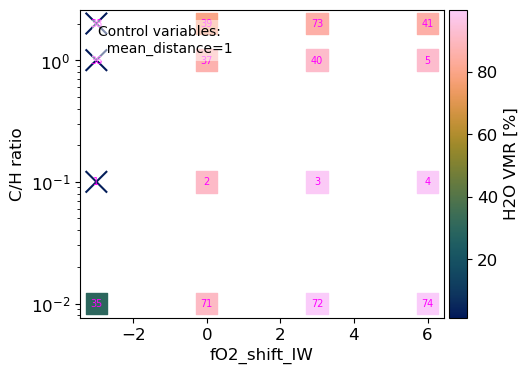

In [22]:
x = cvars["fO2_shift_IW"];  x_lbl = "fO2_shift_IW"; logx = False 
y = cvars["CH_ratio"];      y_lbl = "C/H ratio";    logy = True

# z = endp * 1.0e-5; z_lbl = "Surface pressure [bar]"
# z = endt * 1.0e-6;  z_lbl = "Termination [Myr]"
z = cvars["H2O_surf"] * 100; z_lbl = "H2O VMR [%]"
control = {"mean_distance":1.0}

plot_controls = True
plot_casenums = True
logz = False

make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, plot_casenums=plot_casenums, plot_controls=plot_controls, logx=logx, logy=logy, logz=logz)
plt.show()


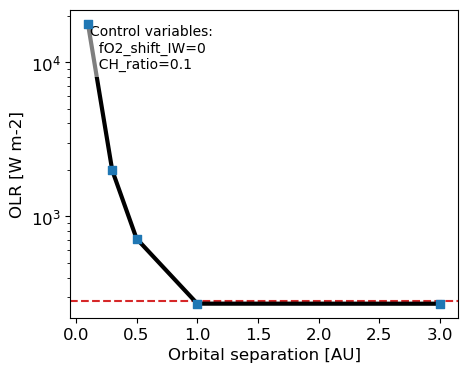

In [21]:
x = cvars["mean_distance"];  x_lbl = "Orbital separation [AU]"; logx = False
z = np.array([ endn[i]["fl_U_LW"][0] for i in range(ncases) ]); z_lbl = "OLR [W m-2]"
# z = endt * 1.0e-3; z_lbl = "Termination time [yr]"
control = {"fO2_shift_IW":0, "CH_ratio":0.1}

plot_controls = True
logz = True

fig,ax = make_p1d(x,x_lbl, z,z_lbl, control, plot_controls=plot_controls, logx=logx, logz=logz)
ax.axhline(y=280, linestyle='dashed',zorder=2, label="SN Limit", color='tab:red')
plt.show()

